In [ ]:
# dataloader testing

import numpy as np
import glob
import os
from PIL import Image

path = "/home/ICT2000/chenh/Haiwei/Datasets/OWT/Catalina_Full/OutputImageSegmentation_Catalina/Images" 

files = glob.glob(os.path.join(path,'*.JPG'))
files_seg = [f[:-4] + '.npy' for f in files]

seg = np.load(files_seg[0])
segmentation = (seg * (seg > -1)).astype(np.uint8)

n_labels = 3
flatseg = np.ravel(segmentation)
onehot = np.zeros((flatseg.size, n_labels), dtype=np.bool)
onehot[np.arange(flatseg.size), flatseg] = True
onehot = onehot.reshape(segmentation.shape + (n_labels,)).astype(int)
segmentation = onehot



In [1]:
# eval testing

# load config for transformer
from omegaconf import OmegaConf
config_path = "configs/owt_transformer.yaml"
config = OmegaConf.load(config_path)
import yaml
# print(yaml.dump(OmegaConf.to_container(config)))

config ['data']['params']['batch_size'] = 1
config['data']['params']['train']['params']['dataroot'] = "/home/ICT2000/chenh/Haiwei/Datasets/OWT/Catalina_Full/OutputImageSegmentation_Catalina/Images/"

# instantiate model
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)

# loading checkpoint
import torch
ckpt_path = "logs/ckpt/owt_transformer_256.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/ckpt/owt_vggan_256.ckpt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/ckpt/owt_seg_vggan_256.ckpt


In [4]:
# dataset instantiation
import importlib
from torch.utils.data import random_split, DataLoader, Dataset

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()
dataset = data.datasets['train']
dataset_iter = iter(data._train_dataloader())


ImgToPath: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1504/1504 [00:00<00:00, 428577.57it/s]


dict_keys(['image', 'segmentation', 'img_path', 'seg_path', 'filename_'])


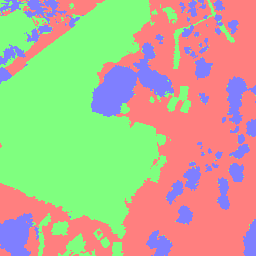

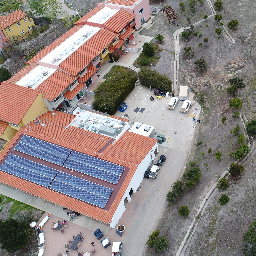

In [14]:
from PIL import Image
import numpy as np
import cv2

idx = 1
batch = dataset[idx]
print(batch.keys())

def write_images(path, image, n_row=1):
    image = ((image + 1) * 255 / 2).astype(np.uint8)
    if image.ndim == 3:
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA)
    cv2.imwrite('{}'.format(str(path)), np.squeeze(image))

def show_image(s, iftorch=False):
  if iftorch:
    s = s.detach().cpu().numpy()[0]
  s = ((s + 1) * 255 / 2).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)
    
segmentation = batch['segmentation']
show_image(segmentation)

image = batch['image']
show_image(image)
write_images('test.png',image)
write_images('test_seg.png',segmentation)


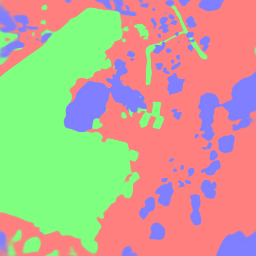

In [11]:
import torch.nn.functional as F

tensify = lambda x: torch.from_numpy(x[None]).permute(0,3,1,2).contiguous().float()
tensor_to_numpy = lambda x:x.detach().numpy()[0].transpose(1,2,0)

seg_tensor = tensify(segmentation)
c_code, c_indices = model.encode_to_c(seg_tensor)
seg_rec = model.cond_stage_model.decode(c_code)
seg_rec = F.softmax(seg_rec,dim=1)
show_image(tensor_to_numpy(seg_rec), False)

In [ ]:
# sample random indices to image VQQGAN
nb = c_code.shape[0]
codebook_size = config.model.params.first_stage_config.params.embed_dim
z_indices_shape = c_indices.shape
c_code_res = 16
res = 256
c_code_res = int(res**0.5)
z_indices_shape = [nb,res]
z_code_shape = [nb, codebook_size,c_code_res, c_code_res]
print(z_code_shape, z_indices_shape)
# z_code_shape = codebook_size
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
print(z_indices.shape)
x_sample = model.decode_to_img(z_indices, z_code_shape)
print(x_sample.shape)
show_image(tensor_to_numpy(x_sample), False)

In [ ]:
## transformer tech
from IPython.display import clear_output
import time

idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

cidx = c_indices
cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

temperature = 1.0
top_k = 100
update_every = 10

start_t = time.time()

print(z_code_shape)

for i in range(0, z_code_shape[2]-0):
  if i <= 8:
    local_i = i
  elif z_code_shape[2]-i < 8:
    local_i = 16-(z_code_shape[2]-i)
  else:
    local_i = 8
  for j in range(0,z_code_shape[3]-0):
    if j <= 8:
      local_j = j
    elif z_code_shape[3]-j < 8:
      local_j = 16-(z_code_shape[3]-j)
    else:
      local_j = 8
    
    i_start = i-local_i
    i_end = i_start+16
    j_start = j-local_j
    j_end = j_start+16
    
    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    cpatch = cidx[:, i_start:i_end, j_start:j_end]
    cpatch = cpatch.reshape(cpatch.shape[0], -1)
    # patch = torch.cat((cpatch, patch), dim=1)
    logits,_ = model.transformer(patch[:,:-1], cpatch)
    logits = logits[:, -256:, :]
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    logits = logits[:,local_i,local_j,:]
    logits = logits/temperature
    
    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)

    step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape)
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
      print(x_sample.shape)
      show_image(tensor_to_numpy(seg_rec), False)
      show_image(tensor_to_numpy(x_sample), False)